**Cel projektu:**
(analiza datasetu) Celem projektu jest: Podwierdzenie dwóch cech będących w największej korelacji ze zdarzeniem śmierci u pacjentów (od strony analizy danych)
(Machine Learning part) Celem projektu zastosowanie znalezienie z pośród zaproponowanych przez autorów klasyfikatorów, najlepszej metody do oceny przeżycia.


**Zbiór danych:** 

Projekt został zrealizowany w oparciu o artykuł: Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5 znaleziony na stronie: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone | BMC Medical Informatics and Decision Making | Full Text (biomedcentral.com) (open access)

**Źródło i opis danych:**
Dane do projektu zostały pobrane ze strony UCI – Machine Learning repository. W źródłach literaturowych artykułu znajduje się bezpośredni link do źródła :  UCI Machine Learning Repository: Heart failure clinical records Data Set (open access)

**Zaimportowanie bibliotek**

In [56]:
## Wizualizacja i przegląd datasetu
import numpy as np
import pandas as pd
import matplotlib as mt 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns #do macierzy korelacji
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #do przekształcenia zmiennych kategorycznych w binarne

## Import bibliotek do części Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# + biblioteki do Neuronal Network
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers



**Zaimportowanie datasetu:**

In [8]:
from google.colab import files
import io

dataset = files.upload()

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset.csv


In [9]:
ds = pd.read_csv(io.StringIO(dataset['heart_failure_clinical_records_dataset.csv'].decode('utf-8')))

**Wizualizacja datasetu wraz z przeglądem danych**

In [10]:
ds.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [11]:
print("Liczba rekordów - wierszy: {}\nLiczba zmiennych: {}".format(ds.shape[0], ds.shape[1]))

Liczba rekordów - wierszy: 299
Liczba zmiennych: 13


In [12]:
## sprawdzimy informację o datasecie
ds.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


* Typy danych, to floar64 i int 64, brak zmiennych kategorycznych trudnych w użytkowaniu do obliczeń ML


In [13]:
#sprawdzenie czy columny mają jakieś wartości, których brakuje
ds.isnull().sum()


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Wygląda na to, że dataset nie ma brakujących wartości w kolumnach

**Przeżycie vs. śmierć**
Autorzy oparli publikację na sprawdzaniu, jakie czynniki wpływają na śmierć pacjenta, dlatego dobrze będzie sprawdzić, jak w datasecie rozkłada się ilość pacjentów, którzy przeżyli.



In [14]:
death = ds[ds["DEATH_EVENT"] == 1].shape[0]
survival = ds[ds["DEATH_EVENT"] == 0].shape[0]
proportion = (death / survival)*100
#rozklad danych
print(f"ilość wszystkich przypadków przeżycia = {survival}")
print(f"ilość wszystkich przypadków śmierci = {death}")
print(f"procent wszystkich przypadków przezycia = {proportion}")



ilość wszystkich przypadków przeżycia = 203
ilość wszystkich przypadków śmierci = 96
procent wszystkich przypadków przezycia = 47.29064039408867


**Wizualizacja danych**

W celu lepszego zwizualizowania danych zdecydowałam się na wizualizację metodą macierzy korelacji. Jej elementy to wrtości współczynników korelacji dla odpowiednich par zmiennych losowych. Dzieki temu będzie można zobaczyć, jaki stopień wzajemnego skorelowania mają konkretne zmienne

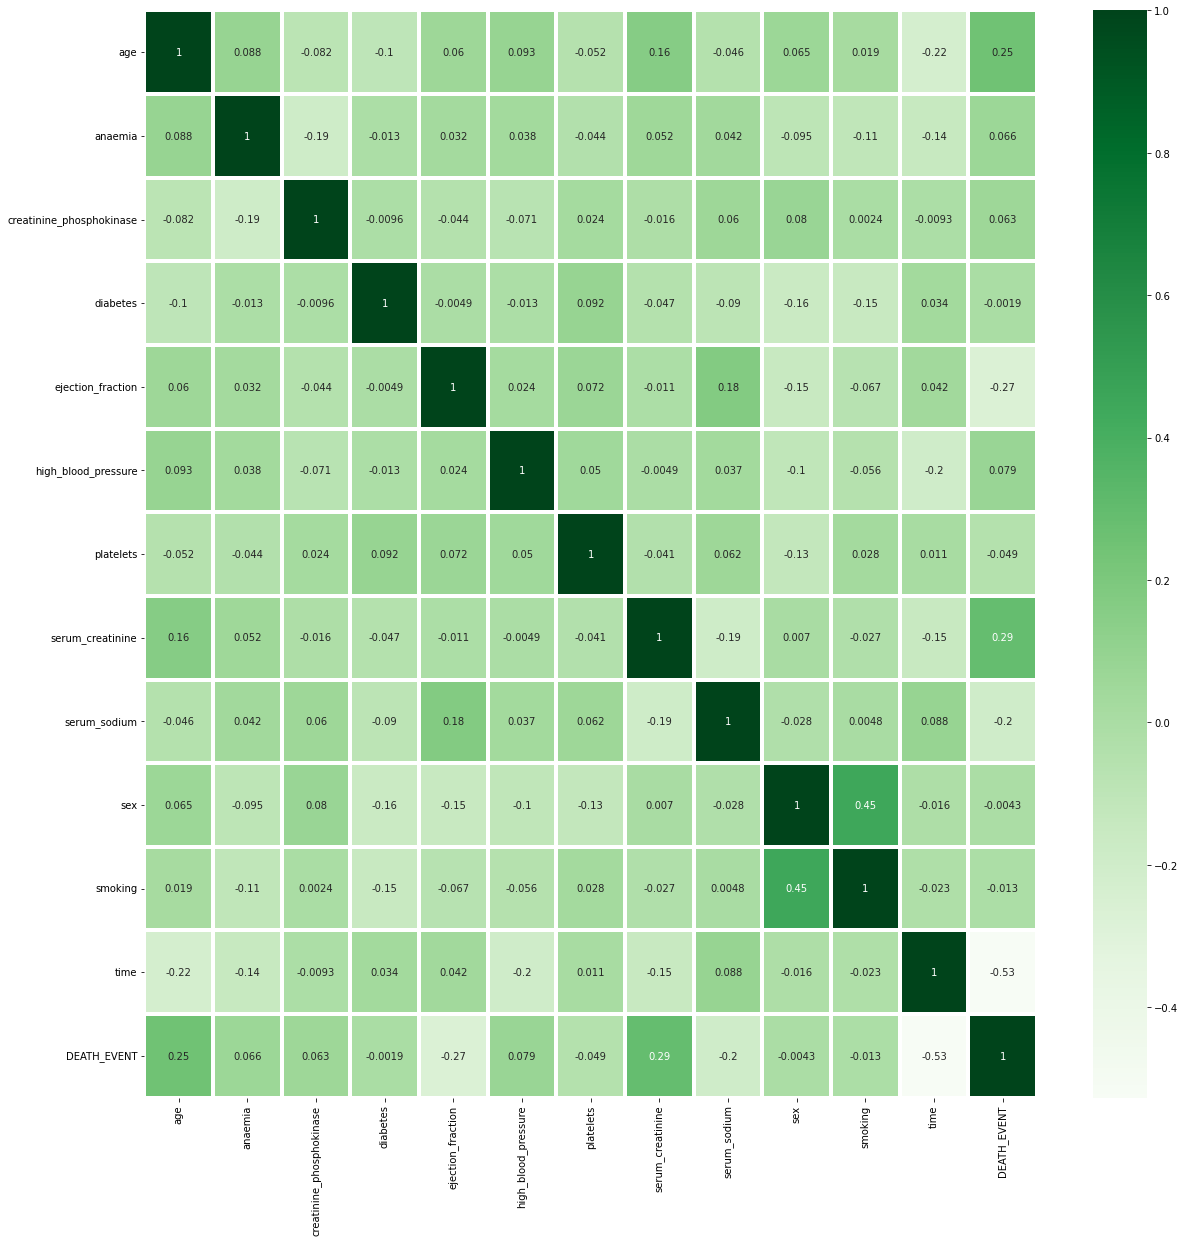

In [15]:
#tworzenie macierzy korelacji
corr = ds.corr() 
corr_features = corr.index
plt.figure(figsize=(20,20)) #rozmiar macierzy

#mapa cieplna
heat_corr = sns.heatmap(ds[corr_features].corr(),annot=True,cmap="Greens", linewidth=3) 
#chyba mój ulubiony kolor dla macierzy korelacji :)



* poszukajmy najbardziej skorelowanych danych z "DEATH_EVENT"


In [16]:
features = ds.corr()
features[abs(features['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

najbardziej skorelowane ze śmiercią zmienne, to:
* age - wiek
* ejection fraction - frakcja wyrzutowa
* serum_creatinine - kreatynina w surowicy
* serum sodium - sód w surowicy
* time - czas obserwacji (tutaj chodzi o czas spędzony w szpitalu - im dłuższy tym poważniejsze uszkodzenie miało miejsce u pacjenta)

Wyniki zbliżone powinny pojawić się w przypadku algorytmów uczenia maszynowego. 



Celem projektu jest przewidzenie przeżycia pacjenta (oszacowane na podstawie the highest accuracy. W tym celu zasosowano kilka algorytmów uczenia mas

**Podział zbioru danych**

Podział danych: Autorzy podzielili dane następująco: 

Zestaw treningowy - 70% pacjentów (0.7) Zestaw testowy - 30% pacjentów (0.3)

Podział względem zmiennej DEATH_EVENT jest kloczowy. Następnie modele implementowane są właśnie względem tego podziału i jednocześnie później zastosowana sztuczna sieć neuronowa ocenia te modele (zbudowane na podstawie wcześniej zbudowanego podziału)

In [17]:
X = ds.drop(['DEATH_EVENT'], axis=1)
y = ds["DEATH_EVENT"]

X.shape, y.shape


((299, 12), (299,))

In [18]:

y.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

**Widać, że rozkład jest niezbalansowany, w związku z tym zastosuję algorytm SMOTE**

In [19]:
X_smote,y_smote = SMOTE().fit_resample(X,y)
y_smote.value_counts()

1    203
0    203
Name: DEATH_EVENT, dtype: int64

**Podział zbioru danych**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, stratify = y_smote, test_size=0.30, train_size=0.70, random_state=50)

print('Rozkład treningowy - X_train:', X_train.shape)
print('Rozkład testowy- X_test:', X_test.shape)
print('Rozkład y-treningowy:', y_train.shape)
print('Rozkład y-testowy:', y_test.shape)

Rozkład treningowy - X_train: (284, 12)
Rozkład testowy- X_test: (122, 12)
Rozkład y-treningowy: (284,)
Rozkład y-testowy: (122,)


**Zastosowanie algorytmów uczenia maszynowego**

W publikcji autorzy zasosowali kilka algorytmów uczenia maszynowego
1. Regresja logistyczna
2. SVM
3. Drzewo decyzyjne
4. Las losowy
5. Gradient Boosting 
6. KNN- K-najbliżsi sąsiedzi

W zastosowaniu algorytmów uczenia maszynowego i zbudowania sieci neuronowej posiłkowałam się zeszytami z zajęc, oraz:
https://github.com/g-shreekant/Heart-Disease-Prediction-using-Machine-Learning/blob/master/Heart_disease_prediction.ipynb

**1. Regresja logistyczna**

In [21]:
regression = LogisticRegression()
model1 = regression.fit(X_train, y_train)
y_pred = model1.predict(X_test)



In [22]:
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
accuracy

              precision    recall  f1-score   support

           0       0.79      0.80      0.80        61
           1       0.80      0.79      0.79        61

    accuracy                           0.80       122
   macro avg       0.80      0.80      0.80       122
weighted avg       0.80      0.80      0.80       122



0.7950819672131147

In [23]:
y_pred.shape

(122,)

In [24]:
score_regression= round(accuracy_score(y_pred ,y_test)*100,2)
score_regression

79.51

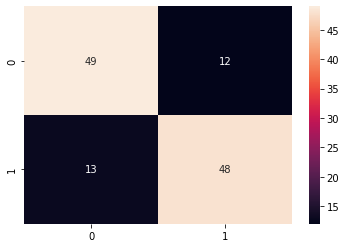

In [25]:
sns.heatmap(confusion_matrix(y_test,y_pred), cbar=True, annot=True)

**2.SVC - Maszyna Wektorów Nośnych**

In [26]:
from sklearn.svm import SVC
vector_machine = SVC(kernel="linear")
model= vector_machine.fit(X_train, y_train)
y_pred = model.predict(X_test)




In [27]:
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
accuracy


              precision    recall  f1-score   support

           0       0.82      0.66      0.73        61
           1       0.71      0.85      0.78        61

    accuracy                           0.75       122
   macro avg       0.76      0.75      0.75       122
weighted avg       0.76      0.75      0.75       122



0.7540983606557377

In [28]:
y_pred.shape

(122,)

In [29]:
score_vector_machine = round(accuracy_score(y_pred ,y_test)*100,2)
score_vector_machine

75.41

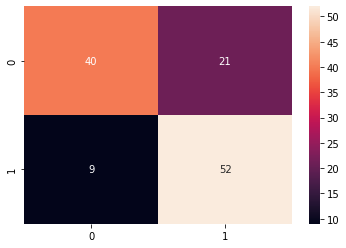

In [30]:

sns.heatmap(confusion_matrix(y_test,y_pred), cbar=True, annot=True)

**3.Drzewo decyzyjne**

In [31]:
decision_tree = DecisionTreeClassifier()
model = decision_tree.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [32]:
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
accuracy


              precision    recall  f1-score   support

           0       0.79      0.82      0.81        61
           1       0.81      0.79      0.80        61

    accuracy                           0.80       122
   macro avg       0.80      0.80      0.80       122
weighted avg       0.80      0.80      0.80       122



0.8032786885245902

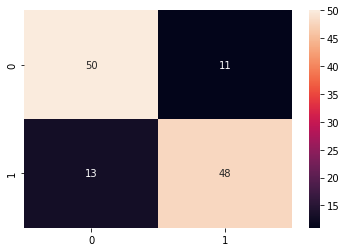

In [33]:
sns.heatmap(confusion_matrix(y_test,y_pred), cbar=True, annot=True)

In [34]:
y_pred.shape

(122,)

In [35]:
score_decision_tree = round(accuracy_score(y_pred ,y_test)*100,2)
score_decision_tree

80.33

**4.Lasy Losowe**

In [36]:
random_forest = RandomForestClassifier(n_estimators=100)
model = random_forest.fit(X_train,y_train)
y_pred = model.predict(X_test)



In [37]:
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
accuracy 


              precision    recall  f1-score   support

           0       0.83      0.89      0.86        61
           1       0.88      0.82      0.85        61

    accuracy                           0.85       122
   macro avg       0.85      0.85      0.85       122
weighted avg       0.85      0.85      0.85       122



0.8524590163934426

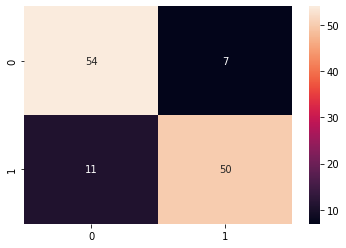

In [38]:
sns.heatmap(confusion_matrix(y_test,y_pred), cbar=True, annot=True)

In [39]:
score_random_forest =(accuracy_score(y_pred ,y_test)*100,2)
score_random_forest

(85.24590163934425, 2)

**5.Gradient Boosting**


In [40]:
gradient_boosting = GradientBoostingClassifier()
model = gradient_boosting.fit(X_train, y_train)
y_pred = model.predict(X_test)




In [41]:

print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
accuracy 


              precision    recall  f1-score   support

           0       0.82      0.84      0.83        61
           1       0.83      0.82      0.83        61

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122



0.8278688524590164

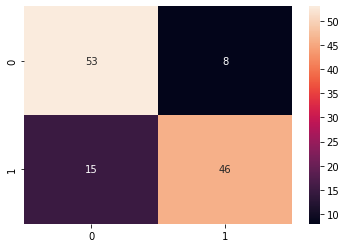

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred), cbar=True, annot=True)

In [42]:
score_gradient_boosting =(accuracy_score(y_pred ,y_test)*100)
score_gradient_boosting

82.78688524590164

**6. K-Nabliżsi sąsiedzi (K-Nearest Neighbor)**


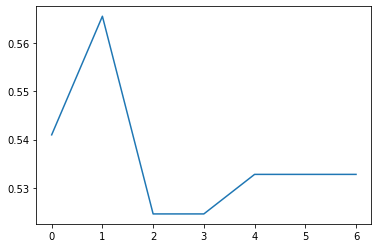

In [45]:
# Sprawdzenie ile sąsiadów powinniśmy uwzględnić:

KNN = []
for neighbors in range(3,10):
    classifier = KNeighborsClassifier(n_neighbors=neighbors)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    KNN.append(accuracy_score(y_test,y_pred))

plt.plot(KNN)


In [47]:
# 2 or 3 neighbors is best option

classification = KNeighborsClassifier(n_neighbors=3)
classification.fit(X_train, y_train)
y_pred = classification.predict(X_test)


In [48]:
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
accuracy 

              precision    recall  f1-score   support

           0       0.54      0.59      0.56        61
           1       0.55      0.49      0.52        61

    accuracy                           0.54       122
   macro avg       0.54      0.54      0.54       122
weighted avg       0.54      0.54      0.54       122



0.5409836065573771

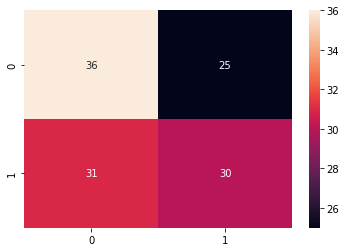

In [49]:
sns.heatmap(confusion_matrix(y_test,y_pred), cbar=True, annot=True)

In [50]:
score_KNN =(accuracy_score(y_pred ,y_test)*100)
score_KNN

54.09836065573771

In [54]:
models = ['Regresja Logistyczna', 'SVM','Drzewo decyzyjne', 'Las Losowy', 'Gradient Boosting', 'K-najbliżsi sąsiedzi']

print(score_random_forest, score_vector_machine,score_decision_tree, score_random_forest, score_gradient_boosting, score_KNN)

(85.24590163934425, 2) 75.41 80.33 (85.24590163934425, 2) 82.78688524590164 54.09836065573771


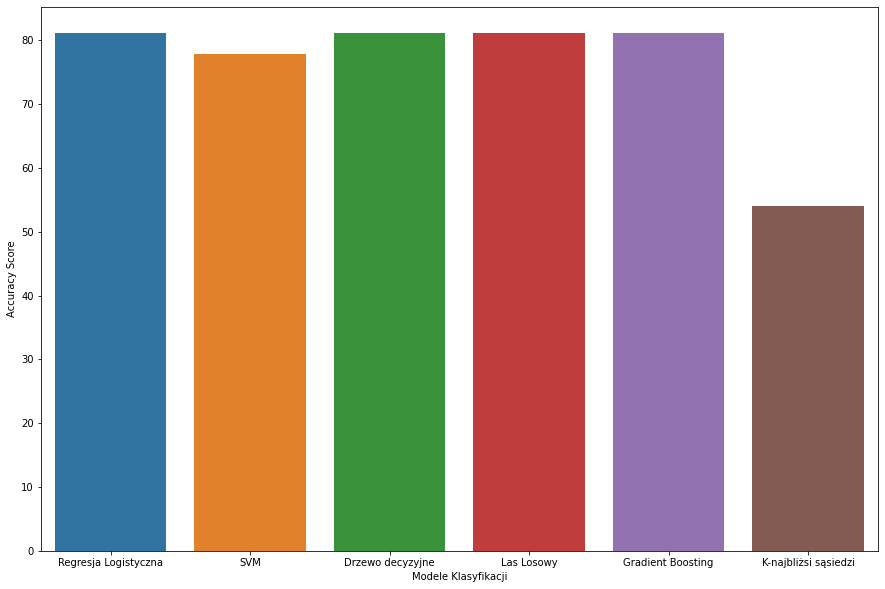

In [55]:
models = ['Regresja Logistyczna', 'SVM','Drzewo decyzyjne', 'Las Losowy', 'Gradient Boosting', 'K-najbliżsi sąsiedzi']

accuracy_score_list =[81.14754098360656, 77.87, 81.15, 81.14754098360656,  81.14754098360656, 54.09836065573771  ]


plt.figure(figsize=(15,10))
sns.barplot(x=models, y=accuracy_score_list)
plt.xlabel('Modele Klasyfikacji')
plt.ylabel('Accuracy Score')
plt.show()

**Komentarz:**

Najlepszy model do oceny zdarzenia śmierci u pacjentów, to las losowy, co pokrywa się z wynikami publikacji

**Implementacja sieci neuronowej**

została stworzona sztuczna sieć neuronowa, która ma na celu ocenić, które z przetestowanych modeli nadają się najlepiej do oceny prawdopobieństwa zdarzenia śmierci. 

In [ ]:
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=12))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, epochs=150)

Epoch 1/150
9/9 [==============================] - 0s 4ms/step - loss: 59.1355 - accuracy: 0.5528
Epoch 2/150
9/9 [==============================] - 0s 3ms/step - loss: 38.4601 - accuracy: 0.5634
Epoch 3/150
9/9 [==============================] - 0s 4ms/step - loss: 17.1286 - accuracy: 0.6479
Epoch 4/150
9/9 [==============================] - 0s 3ms/step - loss: 13.1248 - accuracy: 0.6866
Epoch 5/150
9/9 [==============================] - 0s 4ms/step - loss: 17.2595 - accuracy: 0.6585
Epoch 6/150
9/9 [==============================] - 0s 4ms/step - loss: 24.1046 - accuracy: 0.6232
Epoch 7/150
9/9 [==============================] - 0s 3ms/step - loss: 48.6690 - accuracy: 0.5176
Epoch 8/150
9/9 [==============================] - 0s 3ms/step - loss: 16.7625 - accuracy: 0.6690
Epoch 9/150
9/9 [==============================] - 0s 3ms/step - loss: 33.1039 - accuracy: 0.5775
Epoch 10/150
9/9 [==============================] - 0s 3ms/step - loss: 16.1224 - accuracy: 0.6831
Epoch 11/150
9/9 [=

In [ ]:
y_pred_nn = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [ ]:
y_pred_nn.shape

(122, 1)

In [ ]:
rounded = [round(x[0]) for x in y_pred_nn]

y_pred_nn = rounded

In [ ]:
score_nn = round(accuracy_score(y_pred_nn,y_test)*100,2)

print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

The accuracy score achieved using Neural Network is: 71.31 %


**Ostateczna ocena zastosowanych modeli**

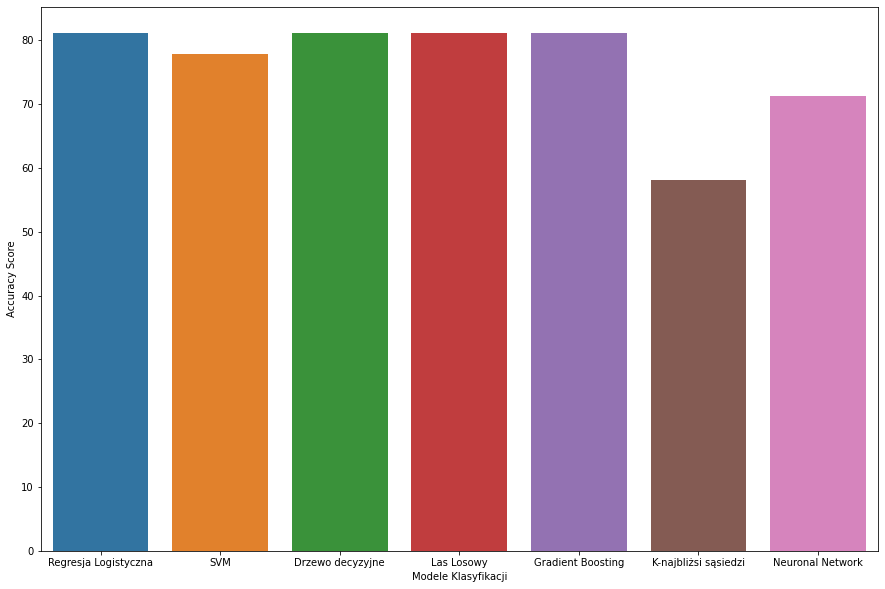

In [57]:
models = ['Regresja Logistyczna', 'SVM','Drzewo decyzyjne', 'Las Losowy', 'Gradient Boosting', 'K-najbliżsi sąsiedzi','Neuronal Network']

accuracy_score_list =[81.14754098360656, 77.87, 81.15, 81.14754098360656,  81.14754098360656, 58.19672131147541, 71.31 ]


plt.figure(figsize=(15,10))
sns.barplot(x=models, y=accuracy_score_list)
plt.xlabel('Modele Klasyfikacji')
plt.ylabel('Accuracy Score')
plt.show()

**Sieć Neuronowa**

In [96]:
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=12))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 11)                143       
                                                                 
 dense_38 (Dense)            (None, 1)                 12        
                                                                 
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
# fit the model to the training data
a =model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=150, batch_size=10)

Epoch 1/150
29/29 [==============================] - 1s 9ms/step - loss: 36429.1211 - accuracy: 0.5000 - val_loss: 31765.1816 - val_accuracy: 0.5000
Epoch 2/150
29/29 [==============================] - 0s 4ms/step - loss: 25609.0098 - accuracy: 0.5000 - val_loss: 20440.4160 - val_accuracy: 0.5000
Epoch 3/150
29/29 [==============================] - 0s 4ms/step - loss: 15240.7451 - accuracy: 0.5000 - val_loss: 10682.1953 - val_accuracy: 0.5000
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 5735.8618 - accuracy: 0.5000 - val_loss: 853.7404 - val_accuracy: 0.5000
Epoch 5/150
29/29 [==============================] - 0s 5ms/step - loss: 549.9177 - accuracy: 0.4965 - val_loss: 137.2326 - val_accuracy: 0.5246
Epoch 6/150
29/29 [==============================] - 0s 4ms/step - loss: 117.8762 - accuracy: 0.4542 - val_loss: 110.2772 - val_accuracy: 0.5246
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 105.4371 - accuracy: 0.4859 - val_loss: 120.

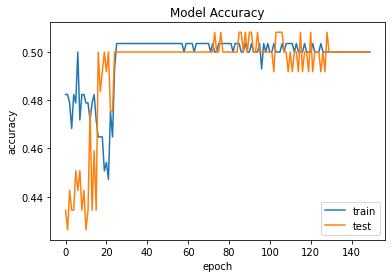

In [98]:
# Wyplotowanie model accuracy

%matplotlib inline

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

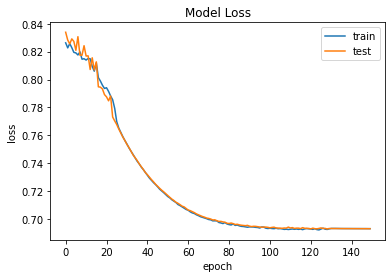

In [99]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
#accuracy dla modelu uczenia maszynowego wychodzi nieco ponad 0,50. W związku z tym najlepszy model do przewidywania 
#ryzyka śmiercli u pacjentów względem innych zmiennych daje nadal las losowy